<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Pytorch/blob/main/NN_Micrograd_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import numpy as np 
import math 
import matplotlib.pyplot as plt 

Understanding the Micrograd from fundamental level.  

https://github.com/karpathy/micrograd

In [2]:
# Scalar value function 
def f(x):
  return 3*x**2 - 4*x + 5 


In [3]:
f(3.0)

20.0

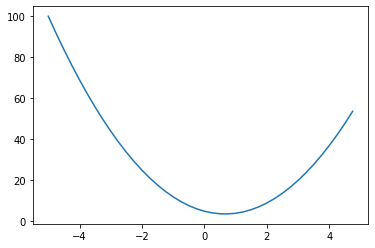

In [4]:
# Plotting the function 
xs = np.arange(-5 , 5 , 0.25) # range of values for the function 
ys = f(xs)


plt.plot(xs , ys ); # a parabola

What is the derivative of this function at any point of x / different value of x? 


\begin{align}
{\displaystyle L=\lim _{h\to 0}{\frac {f(a+h)-f(a)}{h}}}
\end{align}


If we bump up the h, how the function responds and what sensitivity does it respond? Whats the slope? Does it go up or down? 


In [5]:
# Taking the small h 
h = 0.001
x = 3.0 
f(x)

20.0

In [6]:
# With h 
f(x + h)

20.014003000000002

Here we go positively so the function goes +ve. So the slope is also greater than 20. 

Now we will calculate the strength or the size of the slope. 

In [7]:
# change of value in a positive direction 
f(x + h) - f(x) # how much the function responded 

0.01400300000000243

In [8]:
# To get the slope we normalize the rise over run 
h = 0.000000001
x= 3.0
(f(x+h) - f(x)) / h 

14.000001158365194

At `x = 3.0` the slope is `14.000001158365194`

Now when `x = -3.0` what will be the slope? 

In [9]:
h = 0.000000001
x= -3.0
(f(x+h) - f(x)) / h 

-22.000001820288162

We get a negative slope as the function goes down that is below 20 which we had before. 

At some point the slope will be 0. 

In [10]:
# Slope will be zero when, 
h = 0.000000001
x= 2/3 # when 2/3
(f(x+h) - f(x)) / h 

0.0

At this precise point `2/3` the derivative will be zero. This means if nudge the function with the precise point of `h` it wont responsd and stays the same and thats why the slope is zero. 

**Getting Complex**

In [11]:
a = 2.0 
b = -3.0 
c = 10.0

d = a*b + c
print(d)

4.0


Lets check the derivative of function `d` with respect to a, b and c.

In [12]:
h = 0.001 

# Inputs 
a = 2.0 
b = -3.0 
c = 10.0

d1 = a*b + c

In [13]:
# bump a by h 
a += h

d2 = a*b + c 
print("d1: ", d1)
print("d2: ", d2)


d1:  4.0
d2:  3.997


`d2-d1` is how much the function increased when we bumped the value of a by a tiny amount and `h` is the normalizer to get the slope. 

In [14]:
print('slope: ', (d2 - d1)/h) 

slope:  -3.0000000000001137


If we differentiate `a*b + c` w.r.t `a` then we will get b + c and here the value of b is -3. Thats the slope. 

If we bump `b` in a positive direction we get a different slope. 

In [15]:
# Bumping the b
h = 0.001 

# Inputs 
a = 2.0 
b = -3.0 
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c 

print("d1: ", d1)
print("d2: ", d2)
print('slope: ', (d2 - d1)/h) 

d1:  4.0
d2:  4.002
slope:  1.9999999999997797


Here we differentiate w.r.t to b, so we will get `a`. 

In [16]:
# Bumping the c 

h = 0.001 

# Inputs 
a = 2.0 
b = -3.0 
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c 

print("d1: ", d1)
print("d2: ", d2)
print('slope: ', (d2 - d1)/h) 

d1:  4.0
d2:  4.0009999999999994
slope:  0.9999999999994458


The slope is `0.99999999999458` is the rate at which function d will increase if we scale. 

### Building the `Value` object of micrograd 




In [17]:
# Skeleton of the Value Object 

class Value: 

  def __init__(self , data):
    self.data = data 

  # repr -> gets the string representation of the object 
  def __repr__(self):
    return f"Value(data = {self.data})"

In [19]:
a = Value(2.0)
b = Value(-3.0)

a + b 

TypeError: ignored

In [20]:
# Addition method 
# Skeleton of the Value Object 

class Value: 

  def __init__(self , data , _children = ()):
    self.data = data 
    self._prev = set(_children) # set of children tuple  

  # repr -> gets the string representation of the object 
  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self, other): # a.__add__(b)
    out = Value(self.data + other.data , (self, other))
    return out

  def __mul__(self, other): # a.__mult__(b)
    out = Value(self.data * other.data , (self, other))
    return out

In [21]:
a = Value(2.0)
b = Value(-3.0)

n = a * b 
n._prev

{Value(data = -3.0), Value(data = 2.0)}

In [22]:
a*b 

Value(data = -6.0)

In [23]:
# Multiple operations 
c = Value(10.0)
d = a*b + c 

We need to have some sort of graph where we will be tracking what values produce what other values (like a pointer). 





In [24]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

Above is the value resulting from `a*b` and the `c`

- `a*b` -> Value(-6.0)
- `c` -> Value(10.0)

Now we know the children of every single value but we dont know what operation created this value.

In [35]:
# Creating labels 

# Operation variable 
class Value: 

  def __init__(self , data , _children = () , _op = "", label = ""):
    self.data = data 
    self._prev = set(_children) # set of children tuple  
    self._op = _op
    self.label = label

  # repr -> gets the string representation of the object 
  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self, other): # a.__add__(b)
    out = Value(self.data + other.data , (self, other) , "+")
    return out

  def __mul__(self, other): # a.__mult__(b)
    out = Value(self.data * other.data , (self, other) , "*")
    return out

In [36]:
# Now we know what are the opertions took place 
d = a*b + c 
d._op

'+'

`d` was produced by the addition of two values. 

In [37]:
eq = a * b * c 

In [38]:
eq._prev

{Value(data = -6.0), Value(data = 10.0)}

In [39]:
a, b , c

(Value(data = 2.0), Value(data = -3.0), Value(data = 10.0))

In [40]:
eq._op

'*'

#### Tracing the graph for better visualization 

Function to visualize the root node 

In [41]:
from graphviz import Digraph

def trace(root):

  # Builds set of nodes and edges in a graph 
  nodes , edges = set() , set()
  # Function to build 
  def build(v):
    # Checking for the Value Object
    if v not in nodes:
      nodes.add(v) # Value

      # Iterating the children stored in the value 
      for child in v._prev:
        edges.add((child , v)) # Children and the value associated
        build(child)
  build(root)
  return nodes, edges

In [42]:
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
  
        dot.node(name=str(id(n)), label = "{ %s| data %.4f }" % (n.label, n.data ), shape='record')
    
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [45]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c 

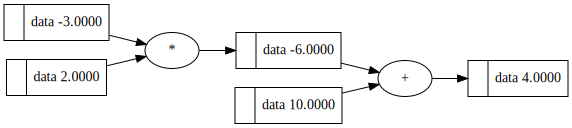

In [46]:
draw_dot(d)

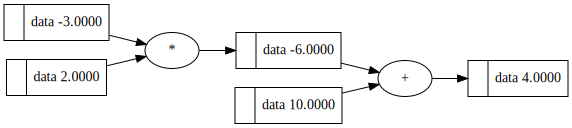

In [47]:
draw_dot(d)

In [48]:
# Creating labels 

# Operation variable 
class Value: 

  def __init__(self , data , _children = () , _op = "", label = ""):
    self.data = data 
    self._prev = set(_children) # set of children tuple  
    self._op = _op
    self.label = label

  # repr -> gets the string representation of the object 
  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self, other): # a.__add__(b)
    out = Value(self.data + other.data , (self, other) , "+")
    return out

  def __mul__(self, other): # a.__mult__(b)
    out = Value(self.data * other.data , (self, other) , "*")
    return out

In [49]:
a = Value(2.0 , label= "a")
b = Value(-3.0 , label = "b")
c = Value(10.0 , label = 'c')

e = a*b; e.label = "e"
d = e + c; d.label = 'd'

f = Value(-2.0 , label = 'f')

L = d *f ; L.label = "L"
L

Value(data = -8.0)

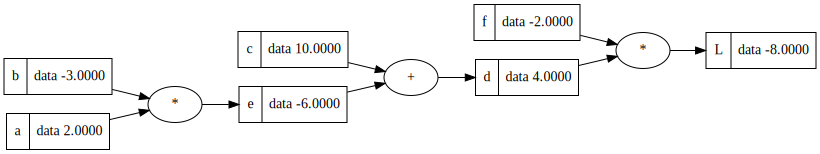

In [50]:
draw_dot(L)

The above is the forward pass with the scalar values we have and we built out a mathematical expression. 

Next we will calculate the backpropagation where we will calculate the gradients by reversing the order of all the intermediate values.

So in this case, we will calculate the derivative of L w.r.t to each of the variables. Some of the variables we've represents the weights of a neural network we have. 

So during the backprop the network is very much interested on the derivative of the loss function w.r.t its weights. 


In [51]:
# Creating labels 

# Operation variable 
class Value: 

  def __init__(self , data , _children = () , _op = "", label = ""):
    self.data = data 
    self._prev = set(_children) # set of children tuple  
    self._op = _op
    self.label = label
    self.grad = 0.0 # Means no effect at initial

  # repr -> gets the string representation of the object 
  def __repr__(self):
    return f"Value(data = {self.data})"

  def __add__(self, other): # a.__add__(b)
    out = Value(self.data + other.data , (self, other) , "+")
    return out

  def __mul__(self, other): # a.__mult__(b)
    out = Value(self.data * other.data , (self, other) , "*")
    return out

In [52]:
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
  
        dot.node(name=str(id(n)), label = "{ %s| data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
    
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

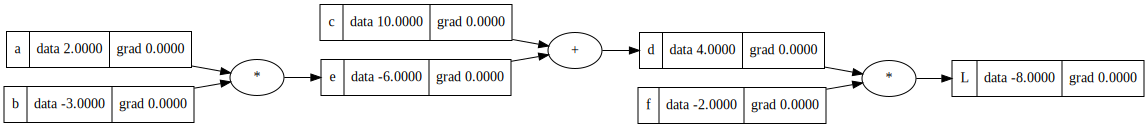

In [53]:
a = Value(2.0 , label= "a")
b = Value(-3.0 , label = "b")
c = Value(10.0 , label = 'c')

e = a*b; e.label = "e"
d = e + c; d.label = 'd'

f = Value(-2.0 , label = 'f')

L = d *f ; L.label = "L"

draw_dot(L)

`grad` -> shows the derivative of the variables [a,b,c,d..] w.r.t to the loss function `L`. 

`dL / da` 